In [1]:
import nibabel as nib
import numpy as np
import pandas as pd
import nilearn.plotting as nip
import seaborn as sns
from matplotlib.colors import ListedColormap
from nibabel.affines import apply_affine
import numpy.linalg as npl
from nilearn.reporting import get_clusters_table
from scipy.ndimage import distance_transform_edt

from nilearn.datasets import fetch_atlas_difumo
difumo_data = fetch_atlas_difumo(dimension=128, resolution_mm=2, data_dir=None, resume=True, verbose=1, legacy_format=False)
# load 4d image and fetch the first volume
difumo_4d = nib.load(difumo_data['maps'])

def get_difumo_label(world_coord):
    voxel_coord = apply_affine(npl.inv(difumo_4d.affine), world_coord).astype(int)
    max = np.max(difumo_4d.get_fdata()[voxel_coord[0], voxel_coord[1], voxel_coord[2], :])
    argmax = np.argmax(difumo_4d.get_fdata()[voxel_coord[0], voxel_coord[1], voxel_coord[2], :])
    location = difumo_data['labels'].iloc[argmax, :]
    return location['difumo_names'], location['yeo_networks7'], max


mars_labelmap = nib.load('../resources/MNI152_nonlin_MarsAtlas.nii.gz')
mars_labels = pd.read_csv('../resources/MarsLabels_long.csv', index_col=False)

def get_mars_label(world_coord, max_radius=10):
    voxel_coord = apply_affine(npl.inv(mars_labelmap.affine), world_coord).astype(int)
    labelmap_data = mars_labelmap.get_fdata()
    nonzero_mask = labelmap_data > 0
    # Compute distance transform
    distances, indices = distance_transform_edt(~nonzero_mask, return_indices=True)
    # Get the closest non-zero label within the max_radius
    closest_voxel_coord = indices[:, voxel_coord[0], voxel_coord[1], voxel_coord[2]]
    # Ensure the closest voxel is within max_radius
    distance_to_closest = distances[tuple(voxel_coord)]
    if distance_to_closest > max_radius:
        return 0  # Return 0 if no non-zero label is within the radius
    label = labelmap_data[closest_voxel_coord[0], closest_voxel_coord[1], closest_voxel_coord[2]]
    res = mars_labels.loc[mars_labels['Index'] == label, :].copy()
    res.loc[:, 'Distance'] = distance_to_closest
    return res
   

dir_mediation = '/Users/tspisak/data/PIC_conditioning_withinsub_nodatalad/mediation_signflipped_signedquantile_results'
data4d_harmonized = nib.load(f'{dir_mediation}/../all_data_studyranked.nii')
pheno = pd.read_csv(f'{dir_mediation}/../signatures.csv')
# get mean effect in each group for a given voxel
def get_stats(voxel_coord, stat_fun, data4d=data4d_harmonized, pheno=pheno):
    data = data4d.get_fdata()[voxel_coord[0], voxel_coord[1], voxel_coord[2], :]
    return stat_fun(data, pheno)

def stat_fun_groupmeans(data, pheno):
    return np.mean(data[pheno['Conditioning']=='suggestions']), np.mean(data[pheno['Conditioning']=='suggestions & conditioning'])

def stat_fun_percgt0(data, pheno):
    mean_INT, mean_CONDINT = stat_fun_groupmeans(data, pheno)
    return (mean_INT+0.5)*100, (mean_CONDINT+0.5)*100 #weighted average (across studies) of the % of participants with a positive effect

my_cmp = ListedColormap(['cyan', 'blue', 'white', 'white', 'red', 'orange'])

/Users/tspisak/src/placebo-conditioning-meta-analysis/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
mask = nib.load(f'{dir_mediation}/../full_masked_10_percent.nii')
mask_data = mask.get_fdata()

contrast = [
    "PathA(XM)",
    "PathB(MY)",
    "Indirect(ACME)",
    "Direct(Total-Indirect)",
    "INST_mean",
    "CONDINST_mean",
    "INSTandCONDINST",
    ]
img_type = ['beta', 'thres', 'uncorr_logp', 'fdr_logq']

img = {}
for c in contrast:
    img[c] = {}
    for t in img_type:
        img[c][t] = nib.load(f'{dir_mediation}/{t}_{c}.nii.gz')

In [3]:
# Nichols' conjunction analysis
from scipy.stats import false_discovery_control

logp_condist = img['CONDINST_mean']['uncorr_logp'].get_fdata()
logp_inst = img['INST_mean']['uncorr_logp'].get_fdata()
minlogp = np.minimum(logp_condist, logp_inst)
# save uncorr maxp
conjunction_map = nib.Nifti1Image(minlogp, img['PathA(XM)']['beta'].affine)
nib.save(conjunction_map, f'{dir_mediation}/uncorr_logp_INSTandCONDINST_Nichols.nii.gz')
#fdr: 
fdrq_conjunction_Nichols = false_discovery_control(10**(-minlogp), method="bh")
# save fdr conjunction
conjunction_map = nib.Nifti1Image(-np.log10(fdrq_conjunction_Nichols), img['PathA(XM)']['beta'].affine)
nib.save(conjunction_map, f'{dir_mediation}/fdr_logq_INSTandCONDINST_Nichols.nii.gz')
# thresholded map

min_beta = img['INSTandCONDINST']['beta'].get_fdata()

res = np.zeros_like(fdrq_conjunction_Nichols)
res[minlogp>-np.log10(0.01)] = 1
res[fdrq_conjunction_Nichols<0.05] = 2
res[min_beta<0] *= -1
nib.save(nib.Nifti2Image(res, affine=img['INSTandCONDINST']['beta'].affine), f'{dir_mediation}/thres_INSTandCONDINST_Nichols.nii.gz')

res = np.zeros_like(fdrq_conjunction_Nichols)
res[minlogp>-np.log10(0.05)] = 1
res[fdrq_conjunction_Nichols<0.05] = 2
res[min_beta<0] *= -1
nib.save(nib.Nifti2Image(res, affine=img['INSTandCONDINST']['beta'].affine), f'{dir_mediation}/thres05_INSTandCONDINST_Nichols.nii.gz')

In [4]:
img['INSTandCONDINST_Nichols'] = {}
img['INSTandCONDINST_Nichols']['thres'] = nib.load(f'{dir_mediation}/thres_INSTandCONDINST_Nichols.nii.gz')
img['INSTandCONDINST_Nichols']['uncorr_logp'] = nib.load(f'{dir_mediation}/uncorr_logp_INSTandCONDINST_Nichols.nii.gz')
img['INSTandCONDINST_Nichols']['fdr_logq'] = nib.load(f'{dir_mediation}/fdr_logq_INSTandCONDINST_Nichols.nii.gz')
img['INSTandCONDINST_Nichols']['beta'] = img['INSTandCONDINST']['beta'] # stays the same

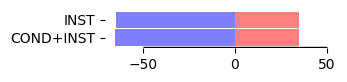

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
plt.style.use('default')

def bars(x, y, z):
    #world to voxel
    fig = plt.figure(figsize=(3, 0.5))
    x, y, z = apply_affine(npl.inv(img['PathA(XM)']['beta'].affine), (x, y, z)).astype(int)
    condinst = (img['CONDINST_mean']['beta'].get_fdata()[x, y, z]+0.5)*100 # % of participants with a positive effect
    inst = (img['INST_mean']['beta'].get_fdata()[x, y, z]+0.5)*100

    # plot horizontal barplot
    plt.barh(['COND+INST', 'INST'], [condinst, inst], height=0.9, color=to_rgba('red', 0.5))
    plt.barh(['COND+INST', 'INST'], [condinst-100, inst-100], height=0.9, color=to_rgba('blue', 0.5))
    plt.xticks([-50, 0, 50])
    #plt.axline((-10, 0.5), (0, 0.5), color='black', linewidth=1)
    plt.hlines(y=-0.5, xmin=-50, xmax=50, color='black', linewidth=1)
    #plt.tight_layout()
    sns.despine(left=True, bottom=True)
    #return df

# test it
bars(-10, 0, 0)

## MricroGL scripts
We select slices with at least n_sign significant voxels

In [6]:
# search for slices with fdr
def fdr_slices(contrast, n_sign=4):
    data = img[contrast]['thres'].get_fdata()
    zcoords = []
    for i in range(data.shape[2]):
        if np.sum(np.abs(data[:,:,i])>0)>=n_sign:
            #print(i, np.min(data[:,:,i]), np.max(data[:,:,i]), np.sum(np.abs(data[:,:,i])==2))
            # convert to world coordinate
            x, y, z = apply_affine(img[contrast]['thres'].affine, (0, 0, i))
            zcoords.append(z)
    zcoords = ' '.join(str(z) for z in zcoords)
    return f'A H -0.1 V -0.1 {zcoords} S X R 0'
    #return np.min(data), np.max(data)

print('INSTandCONDINST_Nichols', fdr_slices('INSTandCONDINST_Nichols', 30))
print('PathA(XM)', fdr_slices('PathA(XM)', 4))
print('PathB(MY)', fdr_slices('PathB(MY)', 6))
#print('Indirect(ACME)', fdr_slices('Indirect(ACME)', 6))




INSTandCONDINST_Nichols A H -0.1 V -0.1 -18.0 -16.0 -12.0 -8.0 -6.0 -4.0 -2.0 0.0 2.0 4.0 6.0 14.0 22.0 24.0 26.0 28.0 30.0 32.0 34.0 48.0 50.0 52.0 54.0 56.0 58.0 S X R 0
PathA(XM) A H -0.1 V -0.1 -34.0 -32.0 -30.0 -28.0 -26.0 -24.0 -22.0 -20.0 -18.0 -16.0 -14.0 -12.0 -10.0 -8.0 -6.0 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 20.0 22.0 24.0 26.0 28.0 30.0 32.0 34.0 36.0 38.0 40.0 42.0 44.0 46.0 48.0 50.0 52.0 54.0 56.0 58.0 64.0 66.0 68.0 S X R 0
PathB(MY) A H -0.1 V -0.1 -44.0 -42.0 -36.0 -34.0 -32.0 -30.0 -28.0 -26.0 -24.0 -22.0 -20.0 -18.0 -16.0 -14.0 -12.0 -10.0 -8.0 -6.0 -4.0 -2.0 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 20.0 22.0 24.0 26.0 28.0 30.0 32.0 34.0 36.0 38.0 40.0 42.0 44.0 46.0 48.0 50.0 52.0 54.0 56.0 58.0 60.0 62.0 64.0 66.0 68.0 70.0 72.0 74.0 S X R 0


In [7]:
nip.view_img(img['INSTandCONDINST_Nichols']['thres']).open_in_browser()

/Users/tspisak/src/placebo-conditioning-meta-analysis/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [8]:
clust_table = get_clusters_table(stat_img=img['INSTandCONDINST_Nichols']['uncorr_logp'],
                                 stat_threshold=-np.log10(0.01),
                                 cluster_threshold=15,
                                 min_distance=20
                                 )

clust_table['region'] = 'N/A'
clust_table['yeo_network'] = 'N/A'

for i, row in clust_table.iterrows():
    x, y, z = row['X'], row['Y'], row['Z']
    x_vox, y_vox, z_vox = apply_affine(npl.inv(img['INSTandCONDINST_Nichols']['beta'].affine), (x, y, z)).astype(int)
    clust_table.loc[row.name, 'Effect size'] = img['INSTandCONDINST_Nichols']['beta'].get_fdata()[x_vox, y_vox, z_vox]
    clust_table.loc[row.name, 'Direction'] = np.sign(clust_table.loc[row.name, 'Effect size'])
    
    clust_table.loc[row.name, 'Mean INST'] = img['INST_mean']['beta'].get_fdata()[x_vox, y_vox, z_vox]+0.5
    clust_table.loc[row.name, 'Mean COND'] = img['CONDINST_mean']['beta'].get_fdata()[x_vox, y_vox, z_vox]+0.5
    
    mars_region = get_mars_label([x, y, z])
    if not isinstance(mars_region, int):
        clust_table.loc[row.name, 'Mars region'] = mars_region['Hemisphere'].values[0] + ' ' + mars_region['Full_name'].values[0] 

    region, yeo_nw, prob = get_difumo_label([x, y, z])
    clust_table.loc[row.name, 'DiFuMo region'] = region
    clust_table.loc[row.name, 'yeo_network'] = yeo_nw

    clust_table.loc[row.name, 'Peak Stat uncorr'] = 10 ** (-row['Peak Stat'])
    if clust_table.loc[row.name, 'Peak Stat uncorr'] < 0.0001:
        clust_table.loc[row.name, 'Peak Stat uncorr'] = '<0.0001'
    clust_table.loc[row.name, 'Peak Stat FDR'] = 10 ** (- img['INSTandCONDINST_Nichols']['fdr_logq'].get_fdata()[x_vox, y_vox, z_vox])
    
    # delete row if peak is not fdr significant
    if clust_table.loc[row.name, 'Peak Stat FDR'] > 0.05:
        clust_table.drop(row.name, inplace=True)
        continue
    
    if clust_table.loc[row.name, 'Peak Stat FDR'] < 0.0001:
        clust_table.loc[row.name, 'Peak Stat FDR'] = '<0.0001'
        

    ### specific for path A
    pgt0_INT, pgt0_CONDINT = get_stats(voxel_coord=(x_vox, y_vox, z_vox), stat_fun=stat_fun_percgt0)
    # weighted average (across studies) of the % of participants with a positive effect
    clust_table.loc[row.name, 'perc_gt0_INT'] = pgt0_INT
    clust_table.loc[row.name, 'perc_gt0_CONDINT'] = pgt0_CONDINT
    # difference in % of participants with a positive effect - when modelling sex and age
    clust_table.loc[row.name, 'perc_gt0_diff'] = pgt0_CONDINT - pgt0_INT

clust_table[['Cluster ID', 'Cluster Size (mm3)', 'X', 'Y', 'Z', 'Mean INST', 'Mean COND',
     'Effect size', 'Peak Stat uncorr', 'Peak Stat FDR', 'Mars region', 'DiFuMo region', 'yeo_network', ]]

/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_36751/3099649348.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<0.0001' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  clust_table.loc[row.name, 'Peak Stat uncorr'] = '<0.0001'
/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_36751/3099649348.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<0.0001' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  clust_table.loc[row.name, 'Peak Stat FDR'] = '<0.0001'


,Cluster ID,Cluster Size (mm3),X,Y,Z,Mean INST,Mean COND,Effect size,Peak Stat uncorr,Peak Stat FDR,Mars region,DiFuMo region,yeo_network
0,1,120,-58.0,-10.0,0.0,0.175581,0.146425,-0.324419,<0.0001,<0.0001,Left Caudal Superior Temporal Cortex,Superior temporal sulcus LH,DefaultB
1,2,800,16.0,-88.0,28.0,0.142254,0.175513,-0.324487,<0.0001,<0.0001,Right Cuneus,Cuneus superior,VisCent
2,3,360,14.0,-94.0,0.0,0.155869,0.201498,-0.298502,<0.0001,<0.0001,Right Caudal Medial Visual Cortex,Calcarine cortex posterior,VisCent
3,4,272,10.0,-64.0,-6.0,0.172087,0.161110,-0.327913,<0.0001,<0.0001,Right Rostral Medial Visual Cortex,Lingual gyrus,VisCent
4,5,376,10.0,-6.0,52.0,0.104441,0.168506,-0.331494,<0.0001,<0.0001,Right Dorsomedial Motor Cortex,Paracingulate gyrus postero-inferior,SomMotA
5,6,336,-4.0,-34.0,16.0,0.115863,0.166236,-0.333764,<0.0001,<0.0001,Left Isthmus Cingulate Cortex,Middle frontal gyrus lateral LH,ContA
6,7,176,-24.0,-92.0,24.0,0.092871,0.114272,-0.385728,<0.0001,<0.0001,Left Cuneus,Superior occipital gyrus,VisCent
7,8,152,-20.0,-10.0,-18.0,0.215280,0.232048,-0.267952,<0.0001,0.000388,Left Hippocampus,Hippocampal fissure,No network found
8,9,168,-30.0,-44.0,60.0,0.155820,0.179177,-0.320823,<0.0001,0.000662,Left Superior Parietal Cortex,Superior parietal lobule anterior,DorsAttnB
9,10,184,-4.0,-78.0,-30.0,0.182585,0.183118,-0.316882,<0.0001,0.001939,NaN,Cerebellum superior posterior fissure,No network found


-4.0 -78.0 -30.0 -0.3168824523675029 0.0019391914260456604 nan Cerebellum superior posterior fissure No network found


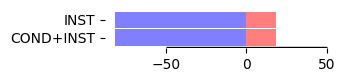

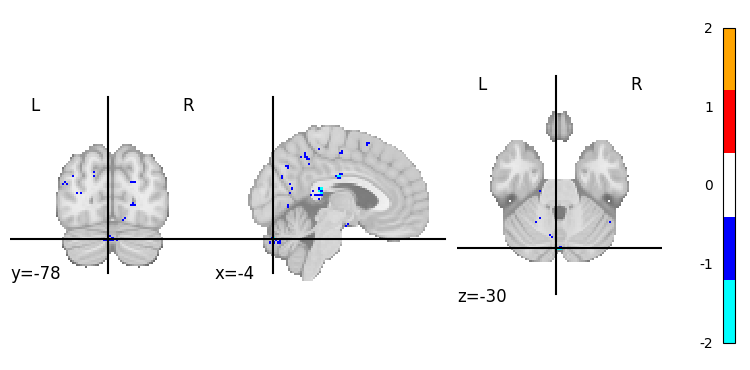

-20.0 -10.0 -18.0 -0.2679517258201728 0.0003879939822078793 Left Hippocampus Hippocampal fissure No network found


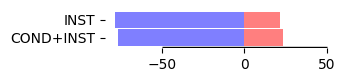

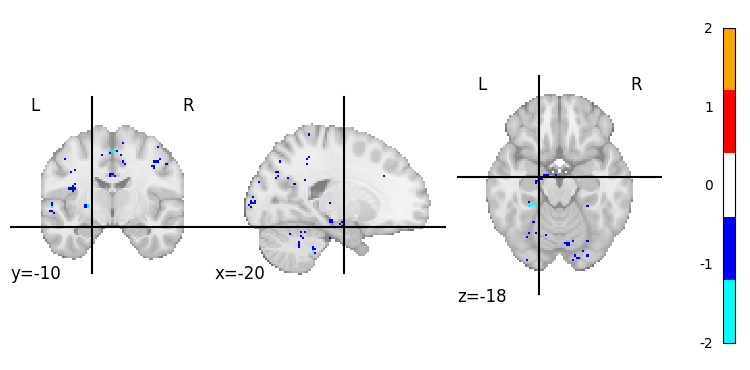

10.0 -64.0 -6.0 -0.32791265618569304 <0.0001 Right Rostral Medial Visual Cortex Lingual gyrus VisCent


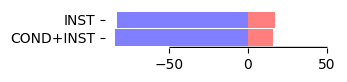

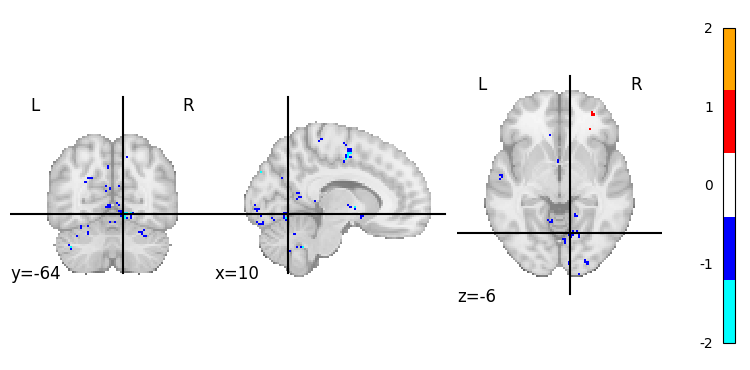

-58.0 -10.0 0.0 -0.3244187242279889 <0.0001 Left Caudal Superior Temporal Cortex Superior temporal sulcus LH DefaultB


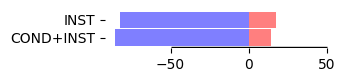

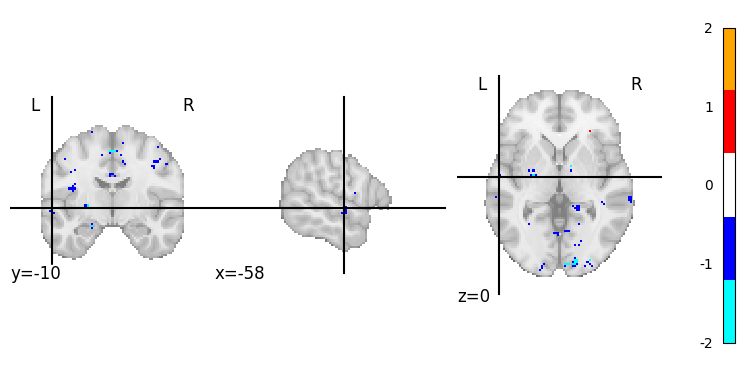

14.0 -94.0 0.0 -0.29850224361639854 <0.0001 Right Caudal Medial Visual Cortex Calcarine cortex posterior VisCent


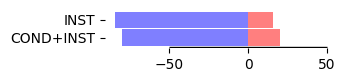

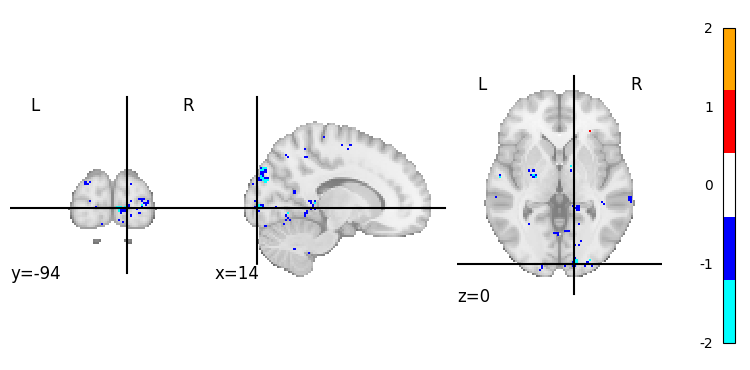

48.0 22.0 4.0 0.32744867736259353 0.024607731759939883 Right Rostral Ventral Premotor Cortex Insula antero-superior SalVentAttnA


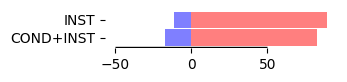

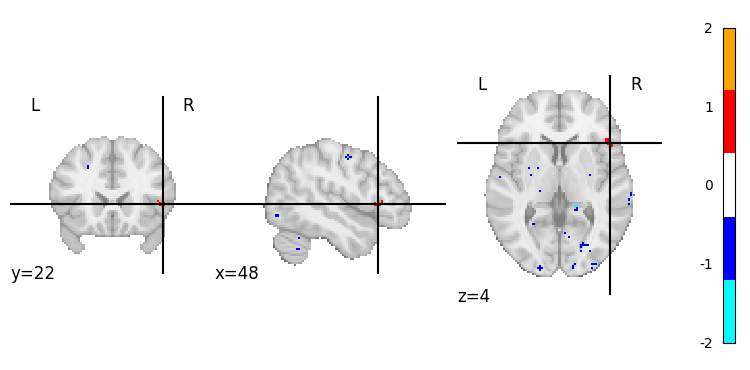

16.0 -38.0 4.0 -0.36001547236693304 0.013637358463710662 Right Hippocampus Middle frontal gyrus lateral LH ContA


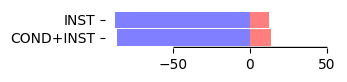

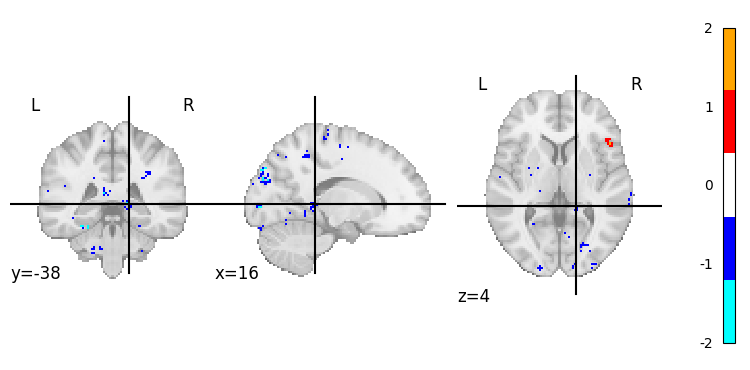

8.0 -54.0 10.0 -0.3687561497879921 0.019173627089957575 Right Posterior Cingulate Cortex Parieto-occipital sulcus anterior DefaultB


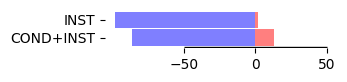

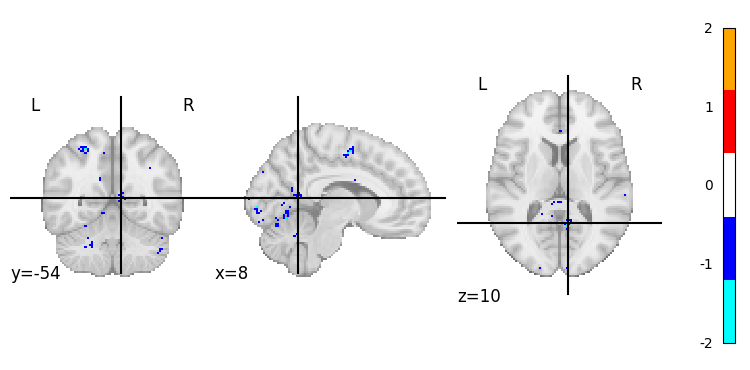

-4.0 -34.0 16.0 -0.3337639071073423 <0.0001 Left Isthmus Cingulate Cortex Middle frontal gyrus lateral LH ContA


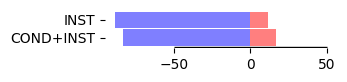

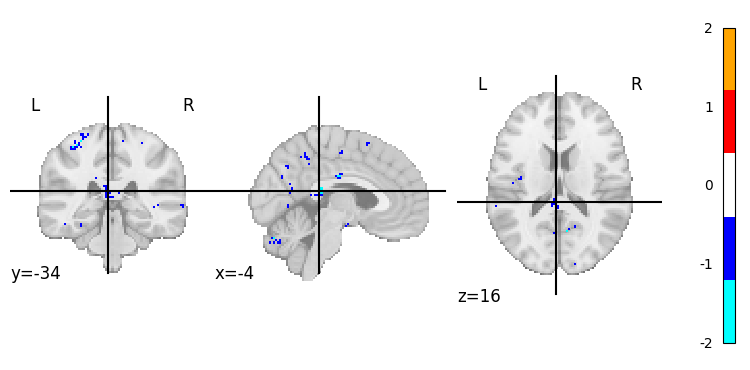

-24.0 -92.0 24.0 -0.38572838948414495 <0.0001 Left Cuneus Superior occipital gyrus VisCent


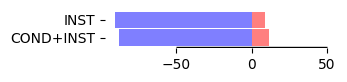

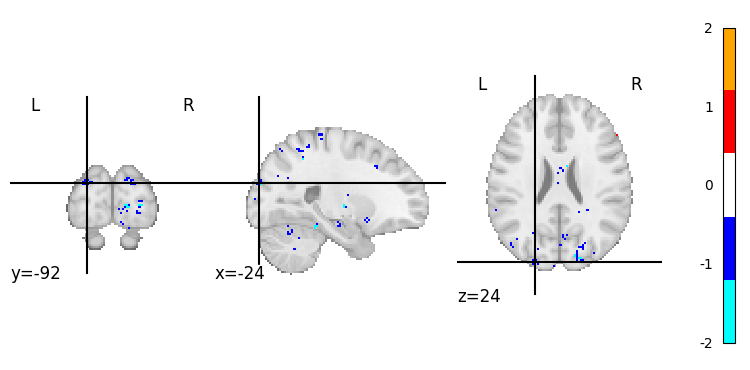

4.0 -70.0 26.0 -0.28440140852787393 0.029969515701719324 Right Medial Parietal Cortex Parieto-occipital sulcus central VisCent


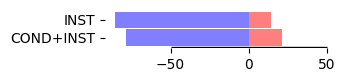

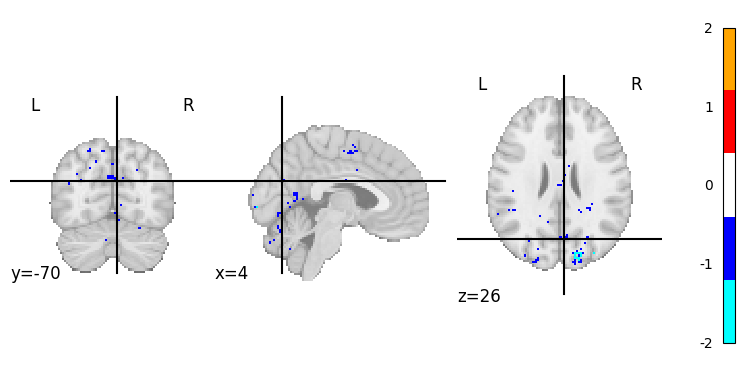

16.0 -88.0 28.0 -0.3244872503703852 <0.0001 Right Cuneus Cuneus superior VisCent


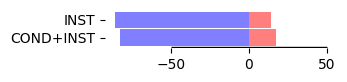

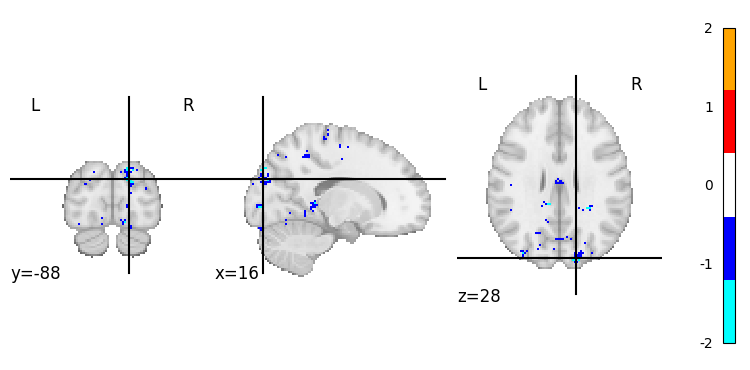

-2.0 -14.0 30.0 -0.4143521164063694 0.004337280651674641 Left Mid Cingulate Cortex Posterior cingulate cortex antero-inferior ContA


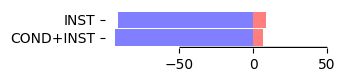

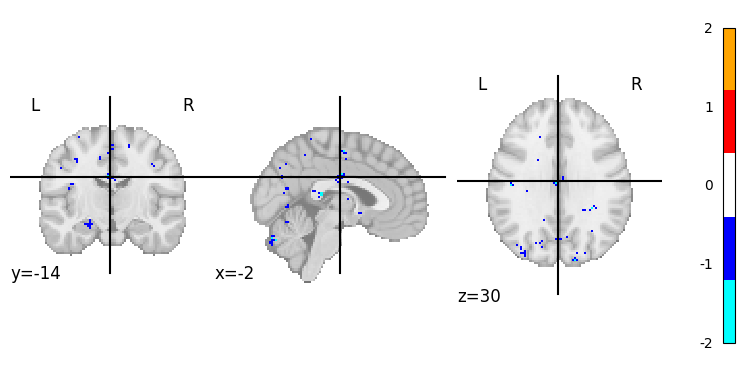

10.0 -6.0 52.0 -0.33149395659785724 <0.0001 Right Dorsomedial Motor Cortex Paracingulate gyrus postero-inferior SomMotA


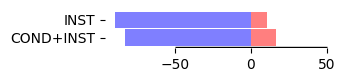

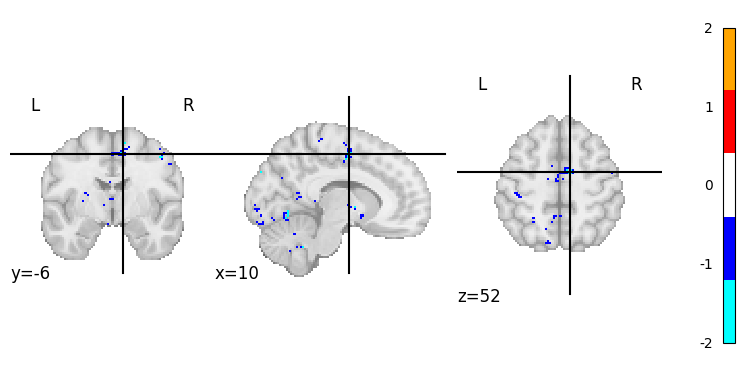

-2.0 -10.0 54.0 -0.30180316146836933 0.009321396556462705 Left Dorsomedial Motor Cortex Paracingulate gyrus postero-inferior SomMotA


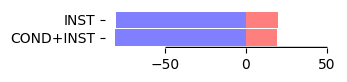

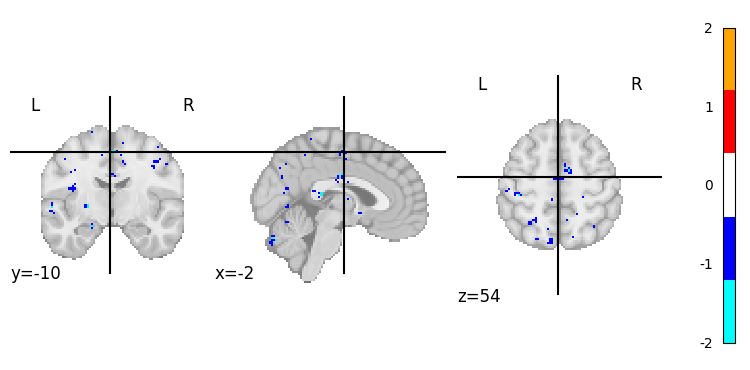

-40.0 -28.0 54.0 -0.30266125486140677 0.02868591483352604 Left Dorsolateral Somatosensory Cortex Postcentral gyrus superior LH SomMotA


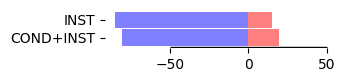

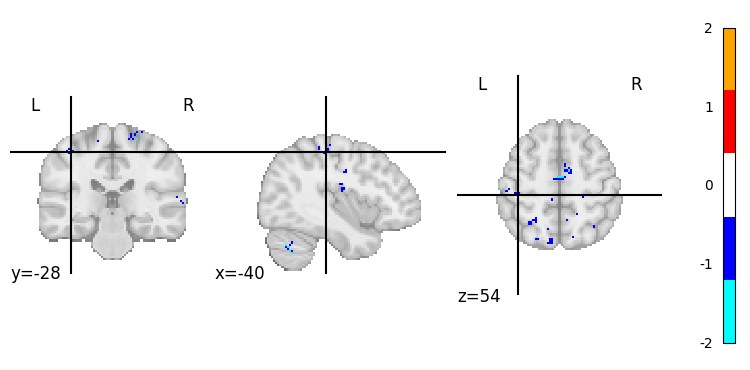

-26.0 -54.0 56.0 -0.32993770883207724 0.009660464931630749 Left Superior Parietal Cortex Superior parietal sulcus DorsAttnB


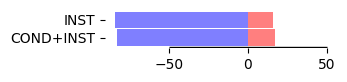

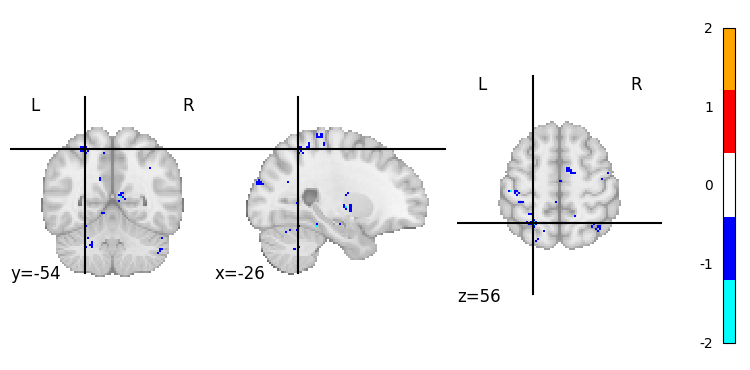

-30.0 -44.0 60.0 -0.32082275379156755 0.0006624704705647793 Left Superior Parietal Cortex Superior parietal lobule anterior DorsAttnB


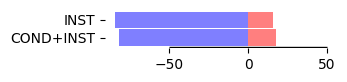

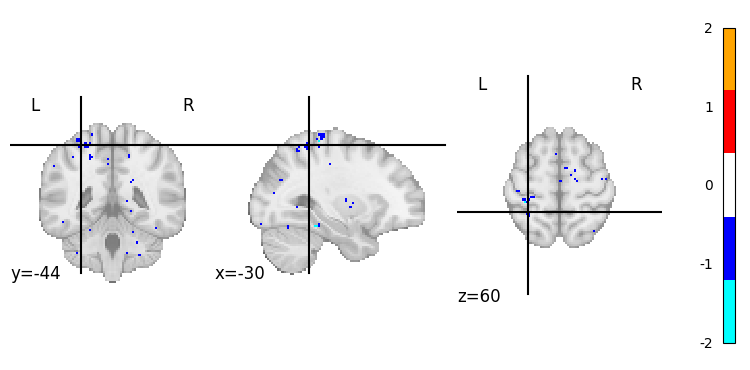

In [52]:
def table2bar(clust_id):
    row = clust_table.loc[clust_table['Cluster ID'] == clust_id, :]
    bars(row['X'].values[0], row['Y'].values[0], row['Z'].values[0])
    # adjust here:
    nip.plot_stat_map(img['INSTandCONDINST_Nichols']['thres'], cut_coords=(row['X'].values[0], row['Y'].values[0], row['Z'].values[0]), draw_cross=True, cmap=my_cmp)
    return row

for i in clust_table.sort_values(by='Z')['Cluster ID']:
    row = table2bar(i)
    print(row['X'].values[0], row['Y'].values[0], row['Z'].values[0], row['Effect size'].values[0], row['Peak Stat FDR'].values[0], row['Mars region'].values[0], row['DiFuMo region'].values[0], row['yeo_network'].values[0])
    plt.show()